# PHASE 4.2: EFFICIENTNET-B0 TRAINING (PyTorch)

**Objective:** Train EfficientNet-B0 with transfer learning for improved accuracy

**Expected Results:**
- Training time: ~2-3 hours (with GPU/MPS) or ~4-6 hours (CPU)
- Validation accuracy: ~88-92%
- Significant improvement over baseline (+15-20%)

**Strategy:**
- Phase 1: Freeze base model, train top layers (~15 epochs)
- Phase 2: Unfreeze, fine-tune entire model (~40 epochs)
- Total: ~55 epochs

## 1. IMPORTS & SETUP

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import time
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Print versions
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

# Check device availability
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f" Running on CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f" Running on Apple Silicon with MPS acceleration")
else:
    device = torch.device('cpu')
    print(f"  Running on CPU only (training will be slower)")

print(f"Device: {device}")

# Set plot style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
        print("  Seaborn style not available, using default")

sns.set_palette("husl")

print("\n All imports successful!")

PyTorch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128
 Running on CUDA GPU: NVIDIA GeForce RTX 3060
Device: cuda

 All imports successful!


## 2. HELPER FUNCTIONS

In [2]:
# Helper function to convert tensors to Python numbers (fix MPS issue)
def to_python(value):
    """Convert tensor to Python number, handling MPS/CUDA devices"""
    if isinstance(value, torch.Tensor):
        return value.cpu().item() if value.numel() == 1 else value.cpu().tolist()
    return value

## 3. CONFIGURATION

In [3]:
#Paths
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')
OUTPUT_DIR = Path('../outputs')

#Create directories
MODEL_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

#OPTIMIZED Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 32 

EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 40

LEARNING_RATE_PHASE1 = 0.001  # Keep same
LEARNING_RATE_PHASE2 = 0.0001  # Keep same

GRADIENT_CLIP_VALUE = 1.0

#Class names
CLASS_NAMES = ['battery', 'biological', 'cardboard', 'glass', 
               'metal', 'paper', 'plastic', 'textile', 'trash']
NUM_CLASSES = len(CLASS_NAMES)

print("⚡ OPTIMIZED Configuration:")
print(f"  Image size: {IMG_SIZE}×{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE} ⚡ (2× faster than before!)")
print(f"  Phase 1 epochs: {EPOCHS_PHASE1} ⚡ (better convergence)")
print(f"  Phase 2 epochs: {EPOCHS_PHASE2}")
print(f"  Total max epochs: {EPOCHS_PHASE1 + EPOCHS_PHASE2}")
print(f"  Gradient clipping: {GRADIENT_CLIP_VALUE} ⚡ (more stable)")
print(f"  Classes: {NUM_CLASSES}")
print(f"\n Optimized configuration set!")


⚡ OPTIMIZED Configuration:
  Image size: 224×224
  Batch size: 32 ⚡ (2× faster than before!)
  Phase 1 epochs: 10 ⚡ (better convergence)
  Phase 2 epochs: 40
  Total max epochs: 50
  Gradient clipping: 1.0 ⚡ (more stable)
  Classes: 9

 Optimized configuration set!


## 4. LOAD CLASS WEIGHTS

In [4]:
#Load class weights
weights_file = DATA_DIR / 'class_weights_simple.json'

with open(weights_file, 'r') as f:
    weights_data = json.load(f)

#Convert to tensor for PyTorch
class_weights_dict = {int(k): v for k, v in weights_data['recommended_weights'].items()}
class_weights_list = [class_weights_dict[i] for i in range(NUM_CLASSES)]
class_weights_tensor = torch.FloatTensor(class_weights_list).to(device)

print("Class weights loaded:")
for class_idx, weight in class_weights_dict.items():
    print(f"  {CLASS_NAMES[class_idx]:12s}: {weight:.4f}")

print("\n Class weights loaded!")


Class weights loaded:
  battery     : 1.8245
  biological  : 1.7504
  cardboard   : 1.9358
  glass       : 0.8578
  metal       : 2.2416
  paper       : 1.6408
  plastic     : 1.9934
  textile     : 0.2360
  trash       : 2.4764

 Class weights loaded!


## 5. CREATE DATA LOADERS

In [5]:
print("Creating optimized data loaders...\n")

#  OPTIMIZED Training transforms - BALANCED augmentation
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),  #  REDUCED: 30→20 (less aggressive)
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),  #  ADJUSTED: 0.75→0.85
    transforms.ColorJitter(brightness=0.15, contrast=0.15,  #  REDUCED: 0.2→0.15
                          saturation=0.15, hue=0.08),  #  REDUCED: 0.1→0.08
    transforms.RandomHorizontalFlip(),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Validation transforms - NO augmentation
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'train',
    transform=train_transforms
)

val_dataset = datasets.ImageFolder(
    root=DATA_DIR / 'val',
    transform=val_transforms
)

#  OPTIMIZED DATA LOADERS (2-3× FASTER!)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,              #  CHANGED: 0 → 4 (parallel loading!)
    pin_memory=True,            # CHANGED: False → True (faster GPU)
    persistent_workers=True,    # ADDED: Keep workers alive
    prefetch_factor=2           #  ADDED: Prefetch batches
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,              # CHANGED: 0 → 2
    pin_memory=True,            # CHANGED: False → True
    persistent_workers=True     # ADDED
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"\n Optimized data loaders created!")
print(f"\n⚡ IMPROVEMENTS:")
print(f"  - Reduced augmentation (better train/val balance)")
print(f"  - Parallel data loading (4 workers)")
print(f"  - Faster GPU transfer (pin_memory)")
print(f"  - Expected: 2-3× faster training!")

Creating optimized data loaders...

Training samples: 10854
Validation samples: 2328
Training batches: 340
Validation batches: 73

 Optimized data loaders created!

⚡ IMPROVEMENTS:
  - Reduced augmentation (better train/val balance)
  - Parallel data loading (4 workers)
  - Faster GPU transfer (pin_memory)
  - Expected: 2-3× faster training!


## 6. BUILD EFFICIENTNET-B0 MODEL

In [6]:
print("Building optimized EfficientNet-B0 model...\n")

# Load pre-trained EfficientNet-B0
base_model = models.efficientnet_b0(weights='IMAGENET1K_V1')

print(f" Base model loaded: EfficientNet-B0")
print(f"   Pre-trained on: ImageNet")

# Get number of features from the last layer
num_features = base_model.classifier[1].in_features

#  OPTIMIZED classifier with REDUCED dropout
base_model.classifier = nn.Sequential(
    nn.Dropout(0.35),  
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.35),  
    nn.Linear(256, NUM_CLASSES)
)

# Move model to device
model = base_model.to(device)

# Freeze base model initially (Phase 1)
for param in model.features.parameters():
    param.requires_grad = False

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n" + "="*70)
print("⚡ OPTIMIZED MODEL STATISTICS")
print("="*70)
print(f"Total parameters:     {total_params:,}")
print(f"Trainable (Phase 1):  {trainable_params:,}")
print(f"Non-trainable:        {total_params - trainable_params:,}")
print(f"\n⚡ OPTIMIZATIONS:")
print(f"  - Dropout: 0.5 → 0.35 (better train/val balance)")
print(f"  - Expected: Higher train acc, similar val acc")
print("="*70)

print("\n Optimized model built successfully!")

Building optimized EfficientNet-B0 model...

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 89.3MB/s]


 Base model loaded: EfficientNet-B0
   Pre-trained on: ImageNet

⚡ OPTIMIZED MODEL STATISTICS
Total parameters:     4,338,309
Trainable (Phase 1):  330,761
Non-trainable:        4,007,548

⚡ OPTIMIZATIONS:
  - Dropout: 0.5 → 0.35 (better train/val balance)
  - Expected: Higher train acc, similar val acc

 Optimized model built successfully!


## 7. TRAINING FUNCTIONS

In [7]:
def train_epoch(model, loader, criterion, optimizer, device, clip_value=1.0):
    """Train for one epoch with gradient clipping"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    pbar = tqdm(loader, desc='Training')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        
        # Backward pass
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_value)
        
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        
        # Update progress bar
        pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    
    return epoch_loss, epoch_acc


def validate_epoch(model, loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validating')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            
            # Update progress bar
            pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects / len(loader.dataset)
    
    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, num_epochs, phase_name, save_path, clip_value=1.0):
    """Train model for specified number of epochs"""
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    best_val_acc = 0.0
    best_model_wts = None
    patience_counter = 0
    patience = 10 if phase_name == 'Phase 1' else 15  # ⚡ INCREASED patience
    
    print(f"\n{'='*70}")
    print(f"⚡ {phase_name.upper()}: OPTIMIZED TRAINING")
    print(f"{'='*70}")
    print(f"Max epochs: {num_epochs}")
    print(f"Patience: {patience}")
    print(f"Gradient clipping: {clip_value}")
    print(f"{'='*70}\n")
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 50)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                           optimizer, device, clip_value)
        
        # Validate
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
        
        # Update scheduler
        old_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_acc)
        new_lr = optimizer.param_groups[0]['lr']
        
        # Log learning rate changes
        if new_lr != old_lr:
            print(f"  📉 Learning rate reduced: {old_lr:.6f} → {new_lr:.6f}")
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)
        
        # Print epoch results
        print(f"\nResults:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
        print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} ({val_acc*100:.2f}%)")
        print(f"  LR: {current_lr:.6f}")
        
        # Calculate train/val gap
        gap = (val_acc - train_acc) * 100
        if gap > 0:
            print(f"   Val > Train gap: {gap:.2f}% (good generalization)")
        else:
            print(f"   Train > Val gap: {-gap:.2f}% (normal)")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict().copy()
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_wts,
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
            }, save_path)
            print(f"   New best model saved! Val Acc: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"  Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\n Early stopping triggered after {epoch+1} epochs")
            break
    
    elapsed_time = time.time() - start_time
    print(f"\n{'='*70}")
    print(f" {phase_name} COMPLETE!")
    print(f"{'='*70}")
    print(f"Best Val Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
    print(f"Training time: {elapsed_time/60:.2f} minutes")
    print(f"{'='*70}\n")
    
    # Load best weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    return history, best_val_acc

print(" Optimized training functions defined!")
print("  - Gradient clipping (more stable training)")
print("  - Increased patience (better convergence)")
print("  - Train/val gap monitoring")

 Optimized training functions defined!
  - Gradient clipping (more stable training)
  - Increased patience (better convergence)
  - Train/val gap monitoring


## 8. PHASE 1: WARMUP TRAINING

Train only the top layers while freezing the base EfficientNet model.

**Expected:** ~15 epochs, ~20-30 minutes, val accuracy ~70-80%

In [8]:
print("\n" + "="*70)
print(" PHASE 1: OPTIMIZED WARMUP TRAINING")
print("="*70)
print(f"Base model: FROZEN")
print(f"Training: Top layers only")
print(f"Expected: 87-89% train, 94-95% val")
print(f"Time: ~15-20 minutes with GPU/MPS")
print("="*70)

# Setup for Phase 1
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer_phase1 = optim.Adam(model.parameters(), lr=LEARNING_RATE_PHASE1)
scheduler_phase1 = ReduceLROnPlateau(optimizer_phase1, mode='max', factor=0.5, 
                                     patience=5, min_lr=1e-7)  # ⚡ Increased patience

# Train Phase 1
history_phase1, best_val_acc_phase1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_phase1,
    scheduler=scheduler_phase1,
    num_epochs=EPOCHS_PHASE1,
    phase_name='Phase 1',
    save_path=MODEL_DIR / 'efficientnet_b0_phase1_optimized.pth',
    clip_value=GRADIENT_CLIP_VALUE
)


 PHASE 1: OPTIMIZED WARMUP TRAINING
Base model: FROZEN
Training: Top layers only
Expected: 87-89% train, 94-95% val
Time: ~15-20 minutes with GPU/MPS

⚡ PHASE 1: OPTIMIZED TRAINING
Max epochs: 10
Patience: 10
Gradient clipping: 1.0


Epoch 1/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.47it/s, loss=0.405] 



Results:
  Train Loss: 0.7636 | Train Acc: 0.7572 (75.72%)
  Val Loss:   0.2987 | Val Acc:   0.9042 (90.42%)
  LR: 0.001000
   Val > Train gap: 14.70% (good generalization)
   New best model saved! Val Acc: 0.9042 (90.42%)

Epoch 2/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.39it/s, loss=0.38]  



Results:
  Train Loss: 0.5705 | Train Acc: 0.8338 (83.38%)
  Val Loss:   0.2527 | Val Acc:   0.9167 (91.67%)
  LR: 0.001000
   Val > Train gap: 8.29% (good generalization)
   New best model saved! Val Acc: 0.9167 (91.67%)

Epoch 3/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.65it/s, loss=0.318] 



Results:
  Train Loss: 0.5165 | Train Acc: 0.8421 (84.21%)
  Val Loss:   0.2457 | Val Acc:   0.9274 (92.74%)
  LR: 0.001000
   Val > Train gap: 8.53% (good generalization)
   New best model saved! Val Acc: 0.9274 (92.74%)

Epoch 4/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 15.60it/s, loss=0.242] 



Results:
  Train Loss: 0.4923 | Train Acc: 0.8495 (84.95%)
  Val Loss:   0.2256 | Val Acc:   0.9248 (92.48%)
  LR: 0.001000
   Val > Train gap: 7.53% (good generalization)
  Patience: 1/10

Epoch 5/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.77it/s, loss=0.245] 



Results:
  Train Loss: 0.4687 | Train Acc: 0.8589 (85.89%)
  Val Loss:   0.2132 | Val Acc:   0.9334 (93.34%)
  LR: 0.001000
   Val > Train gap: 7.46% (good generalization)
   New best model saved! Val Acc: 0.9334 (93.34%)

Epoch 6/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.57it/s, loss=0.238] 



Results:
  Train Loss: 0.4586 | Train Acc: 0.8623 (86.23%)
  Val Loss:   0.2168 | Val Acc:   0.9330 (93.30%)
  LR: 0.001000
   Val > Train gap: 7.07% (good generalization)
  Patience: 1/10

Epoch 7/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.81it/s, loss=0.138] 



Results:
  Train Loss: 0.4381 | Train Acc: 0.8684 (86.84%)
  Val Loss:   0.1718 | Val Acc:   0.9472 (94.72%)
  LR: 0.001000
   Val > Train gap: 7.87% (good generalization)
   New best model saved! Val Acc: 0.9472 (94.72%)

Epoch 8/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.85it/s, loss=0.208] 



Results:
  Train Loss: 0.4189 | Train Acc: 0.8752 (87.52%)
  Val Loss:   0.2020 | Val Acc:   0.9381 (93.81%)
  LR: 0.001000
   Val > Train gap: 6.30% (good generalization)
  Patience: 1/10

Epoch 9/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.68it/s, loss=0.248] 



Results:
  Train Loss: 0.4259 | Train Acc: 0.8673 (86.73%)
  Val Loss:   0.1854 | Val Acc:   0.9394 (93.94%)
  LR: 0.001000
   Val > Train gap: 7.21% (good generalization)
  Patience: 2/10

Epoch 10/10
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.82it/s, loss=0.203] 



Results:
  Train Loss: 0.4017 | Train Acc: 0.8775 (87.75%)
  Val Loss:   0.1611 | Val Acc:   0.9485 (94.85%)
  LR: 0.001000
   Val > Train gap: 7.10% (good generalization)
   New best model saved! Val Acc: 0.9485 (94.85%)

 Phase 1 COMPLETE!
Best Val Accuracy: 0.9485 (94.85%)
Training time: 4.89 minutes



## 9. SAVE PHASE 1 RESULTS

In [9]:
# Save Phase 1 history (with MPS fix)
phase1_df = pd.DataFrame({
    'epoch': range(len(history_phase1['train_loss'])),
    'train_loss': [to_python(v) for v in history_phase1['train_loss']],
    'train_acc': [to_python(v) for v in history_phase1['train_acc']],
    'val_loss': [to_python(v) for v in history_phase1['val_loss']],
    'val_acc': [to_python(v) for v in history_phase1['val_acc']],
    'lr': [to_python(v) for v in history_phase1['lr']],
    'phase': 'Phase 1 Optimized'
})
phase1_df.to_csv(OUTPUT_DIR / 'efficientnet_phase1_optimized_log.csv', index=False)

print(" Phase 1 history saved!")
print(f"   Best validation accuracy: {best_val_acc_phase1:.4f} ({best_val_acc_phase1*100:.2f}%)")

# Compare with original
print("\n COMPARISON WITH ORIGINAL:")
print(f"   Original Phase 1: 92.83% val")
print(f"   Optimized Phase 1: {best_val_acc_phase1*100:.2f}% val")
if best_val_acc_phase1 > 0.9283:
    improvement = (best_val_acc_phase1 - 0.9283) * 100
    print(f"   Improvement: +{improvement:.2f}%!")

print("\n Phase 1 complete! Ready for Phase 2: Fine-tuning entire model...")

 Phase 1 history saved!
   Best validation accuracy: 0.9485 (94.85%)

 COMPARISON WITH ORIGINAL:
   Original Phase 1: 92.83% val
   Optimized Phase 1: 94.85% val
   Improvement: +2.02%!

 Phase 1 complete! Ready for Phase 2: Fine-tuning entire model...


## 10. PHASE 2: FINE-TUNING

Unfreeze all layers and fine-tune the entire model with a lower learning rate.

**Expected:** ~40 epochs, ~2-2.5 hours, val accuracy ~88-95%

In [10]:
print("\n" + "="*70)
print("⚡ PREPARING PHASE 2: OPTIMIZED FINE-TUNING")
print("="*70)

# Unfreeze all layers
for param in model.parameters():
    param.requires_grad = True

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n Base model UNFROZEN")
print(f"   All layers now trainable")
print(f"   Trainable parameters: {trainable_params:,}")

# Setup for Phase 2 with lower learning rate
optimizer_phase2 = optim.Adam(model.parameters(), lr=LEARNING_RATE_PHASE2)
scheduler_phase2 = ReduceLROnPlateau(optimizer_phase2, mode='max', factor=0.5, 
                                     patience=6, min_lr=1e-8)  # ⚡ Increased patience

print(f"\n Model recompiled for fine-tuning")
print(f"   Learning rate: {LEARNING_RATE_PHASE2} (10× lower)")
print(f"   Patience: 6 epochs (more stable)")
print("="*70)

print("\n" + "="*70)
print("⚡ PHASE 2: OPTIMIZED FINE-TUNING")
print("="*70)
print(f"Base model: UNFROZEN (all layers trainable)")
print(f"Training: Entire model")
print(f"Expected: 92-94% train, 96-97% val")
print(f"Time: ~1.5-2 hours with GPU/MPS")
print("="*70)
print("\n☕ Grab a coffee/tea - this will take a while!\n")

# Train Phase 2
history_phase2, best_val_acc_phase2 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_phase2,
    scheduler=scheduler_phase2,
    num_epochs=EPOCHS_PHASE2,
    phase_name='Phase 2',
    save_path=MODEL_DIR / 'efficientnet_b0_best_optimized.pth',
    clip_value=GRADIENT_CLIP_VALUE
)

print("\ Optimized EfficientNet training complete!")

<>:49: SyntaxWarning: invalid escape sequence '\ '
<>:49: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_1560/1050655024.py:49: SyntaxWarning: invalid escape sequence '\ '
  print("\ Optimized EfficientNet training complete!")



⚡ PREPARING PHASE 2: OPTIMIZED FINE-TUNING

 Base model UNFROZEN
   All layers now trainable
   Trainable parameters: 4,338,309

 Model recompiled for fine-tuning
   Learning rate: 0.0001 (10× lower)
   Patience: 6 epochs (more stable)

⚡ PHASE 2: OPTIMIZED FINE-TUNING
Base model: UNFROZEN (all layers trainable)
Training: Entire model
Expected: 92-94% train, 96-97% val
Time: ~1.5-2 hours with GPU/MPS

☕ Grab a coffee/tea - this will take a while!


⚡ PHASE 2: OPTIMIZED TRAINING
Max epochs: 40
Patience: 15
Gradient clipping: 1.0


Epoch 1/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.95it/s, loss=0.0845] 



Results:
  Train Loss: 0.3185 | Train Acc: 0.9025 (90.25%)
  Val Loss:   0.1206 | Val Acc:   0.9622 (96.22%)
  LR: 0.000100
   Val > Train gap: 5.97% (good generalization)
   New best model saved! Val Acc: 0.9622 (96.22%)

Epoch 2/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.84it/s, loss=0.0848] 



Results:
  Train Loss: 0.1906 | Train Acc: 0.9377 (93.77%)
  Val Loss:   0.0750 | Val Acc:   0.9759 (97.59%)
  LR: 0.000100
   Val > Train gap: 3.82% (good generalization)
   New best model saved! Val Acc: 0.9759 (97.59%)

Epoch 3/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.73it/s, loss=0.0245]  



Results:
  Train Loss: 0.1540 | Train Acc: 0.9567 (95.67%)
  Val Loss:   0.0668 | Val Acc:   0.9768 (97.68%)
  LR: 0.000100
   Val > Train gap: 2.01% (good generalization)
   New best model saved! Val Acc: 0.9768 (97.68%)

Epoch 4/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.92it/s, loss=0.0581]  



Results:
  Train Loss: 0.1162 | Train Acc: 0.9642 (96.42%)
  Val Loss:   0.0684 | Val Acc:   0.9777 (97.77%)
  LR: 0.000100
   Val > Train gap: 1.35% (good generalization)
   New best model saved! Val Acc: 0.9777 (97.77%)

Epoch 5/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.81it/s, loss=0.0225]  



Results:
  Train Loss: 0.0895 | Train Acc: 0.9737 (97.37%)
  Val Loss:   0.0650 | Val Acc:   0.9798 (97.98%)
  LR: 0.000100
   Val > Train gap: 0.61% (good generalization)
   New best model saved! Val Acc: 0.9798 (97.98%)

Epoch 6/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.54it/s, loss=0.00576] 



Results:
  Train Loss: 0.0716 | Train Acc: 0.9778 (97.78%)
  Val Loss:   0.0620 | Val Acc:   0.9820 (98.20%)
  LR: 0.000100
   Val > Train gap: 0.42% (good generalization)
   New best model saved! Val Acc: 0.9820 (98.20%)

Epoch 7/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.73it/s, loss=0.00967] 



Results:
  Train Loss: 0.0593 | Train Acc: 0.9817 (98.17%)
  Val Loss:   0.0674 | Val Acc:   0.9820 (98.20%)
  LR: 0.000100
   Val > Train gap: 0.03% (good generalization)
  Patience: 1/15

Epoch 8/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.85it/s, loss=0.000379]



Results:
  Train Loss: 0.0638 | Train Acc: 0.9826 (98.26%)
  Val Loss:   0.0595 | Val Acc:   0.9845 (98.45%)
  LR: 0.000100
   Val > Train gap: 0.19% (good generalization)
   New best model saved! Val Acc: 0.9845 (98.45%)

Epoch 9/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.91it/s, loss=5.46e-5] 



Results:
  Train Loss: 0.0565 | Train Acc: 0.9841 (98.41%)
  Val Loss:   0.0626 | Val Acc:   0.9854 (98.54%)
  LR: 0.000100
   Val > Train gap: 0.13% (good generalization)
   New best model saved! Val Acc: 0.9854 (98.54%)

Epoch 10/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.69it/s, loss=0.00178] 



Results:
  Train Loss: 0.0382 | Train Acc: 0.9898 (98.98%)
  Val Loss:   0.0601 | Val Acc:   0.9858 (98.58%)
  LR: 0.000100
   Train > Val gap: 0.39% (normal)
   New best model saved! Val Acc: 0.9858 (98.58%)

Epoch 11/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.75it/s, loss=0.00308] 



Results:
  Train Loss: 0.0411 | Train Acc: 0.9889 (98.89%)
  Val Loss:   0.0658 | Val Acc:   0.9850 (98.50%)
  LR: 0.000100
   Train > Val gap: 0.40% (normal)
  Patience: 1/15

Epoch 12/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.72it/s, loss=0.000173]



Results:
  Train Loss: 0.0311 | Train Acc: 0.9896 (98.96%)
  Val Loss:   0.0597 | Val Acc:   0.9867 (98.67%)
  LR: 0.000100
   Train > Val gap: 0.29% (normal)
   New best model saved! Val Acc: 0.9867 (98.67%)

Epoch 13/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.82it/s, loss=0.0006]  



Results:
  Train Loss: 0.0330 | Train Acc: 0.9911 (99.11%)
  Val Loss:   0.0529 | Val Acc:   0.9871 (98.71%)
  LR: 0.000100
   Train > Val gap: 0.39% (normal)
   New best model saved! Val Acc: 0.9871 (98.71%)

Epoch 14/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 17.25it/s, loss=0.000379]



Results:
  Train Loss: 0.0311 | Train Acc: 0.9909 (99.09%)
  Val Loss:   0.0455 | Val Acc:   0.9897 (98.97%)
  LR: 0.000100
   Train > Val gap: 0.12% (normal)
   New best model saved! Val Acc: 0.9897 (98.97%)

Epoch 15/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.73it/s, loss=0.000162]



Results:
  Train Loss: 0.0302 | Train Acc: 0.9915 (99.15%)
  Val Loss:   0.0637 | Val Acc:   0.9863 (98.63%)
  LR: 0.000100
   Train > Val gap: 0.53% (normal)
  Patience: 1/15

Epoch 16/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.94it/s, loss=8.84e-5] 



Results:
  Train Loss: 0.0257 | Train Acc: 0.9920 (99.20%)
  Val Loss:   0.0620 | Val Acc:   0.9888 (98.88%)
  LR: 0.000100
   Train > Val gap: 0.32% (normal)
  Patience: 2/15

Epoch 17/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.68it/s, loss=2.37e-5] 



Results:
  Train Loss: 0.0293 | Train Acc: 0.9929 (99.29%)
  Val Loss:   0.0624 | Val Acc:   0.9854 (98.54%)
  LR: 0.000100
   Train > Val gap: 0.75% (normal)
  Patience: 3/15

Epoch 18/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 15.72it/s, loss=8.84e-5] 



Results:
  Train Loss: 0.0203 | Train Acc: 0.9943 (99.43%)
  Val Loss:   0.0609 | Val Acc:   0.9854 (98.54%)
  LR: 0.000100
   Train > Val gap: 0.89% (normal)
  Patience: 4/15

Epoch 19/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 15.36it/s, loss=0.000394]



Results:
  Train Loss: 0.0243 | Train Acc: 0.9929 (99.29%)
  Val Loss:   0.0660 | Val Acc:   0.9867 (98.67%)
  LR: 0.000100
   Train > Val gap: 0.62% (normal)
  Patience: 5/15

Epoch 20/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.99it/s, loss=0.00523] 



Results:
  Train Loss: 0.0239 | Train Acc: 0.9940 (99.40%)
  Val Loss:   0.0684 | Val Acc:   0.9858 (98.58%)
  LR: 0.000100
   Train > Val gap: 0.82% (normal)
  Patience: 6/15

Epoch 21/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.93it/s, loss=0.000742]


  📉 Learning rate reduced: 0.000100 → 0.000050

Results:
  Train Loss: 0.0191 | Train Acc: 0.9945 (99.45%)
  Val Loss:   0.0733 | Val Acc:   0.9854 (98.54%)
  LR: 0.000100
   Train > Val gap: 0.91% (normal)
  Patience: 7/15

Epoch 22/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 15.12it/s, loss=0.000492]



Results:
  Train Loss: 0.0181 | Train Acc: 0.9956 (99.56%)
  Val Loss:   0.0745 | Val Acc:   0.9850 (98.50%)
  LR: 0.000050
   Train > Val gap: 1.06% (normal)
  Patience: 8/15

Epoch 23/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.75it/s, loss=0.000856]



Results:
  Train Loss: 0.0126 | Train Acc: 0.9962 (99.62%)
  Val Loss:   0.0582 | Val Acc:   0.9884 (98.84%)
  LR: 0.000050
   Train > Val gap: 0.78% (normal)
  Patience: 9/15

Epoch 24/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.79it/s, loss=0.000231]



Results:
  Train Loss: 0.0096 | Train Acc: 0.9966 (99.66%)
  Val Loss:   0.0661 | Val Acc:   0.9871 (98.71%)
  LR: 0.000050
   Train > Val gap: 0.95% (normal)
  Patience: 10/15

Epoch 25/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.40it/s, loss=8.16e-5] 



Results:
  Train Loss: 0.0157 | Train Acc: 0.9959 (99.59%)
  Val Loss:   0.0733 | Val Acc:   0.9871 (98.71%)
  LR: 0.000050
   Train > Val gap: 0.87% (normal)
  Patience: 11/15

Epoch 26/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 15.83it/s, loss=7.81e-5] 



Results:
  Train Loss: 0.0143 | Train Acc: 0.9967 (99.67%)
  Val Loss:   0.0607 | Val Acc:   0.9875 (98.75%)
  LR: 0.000050
   Train > Val gap: 0.91% (normal)
  Patience: 12/15

Epoch 27/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 15.80it/s, loss=0.000425]



Results:
  Train Loss: 0.0113 | Train Acc: 0.9969 (99.69%)
  Val Loss:   0.0560 | Val Acc:   0.9888 (98.88%)
  LR: 0.000050
   Train > Val gap: 0.80% (normal)
  Patience: 13/15

Epoch 28/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 15.91it/s, loss=0.000107]


  📉 Learning rate reduced: 0.000050 → 0.000025

Results:
  Train Loss: 0.0099 | Train Acc: 0.9976 (99.76%)
  Val Loss:   0.0596 | Val Acc:   0.9880 (98.80%)
  LR: 0.000050
   Train > Val gap: 0.96% (normal)
  Patience: 14/15

Epoch 29/40
--------------------------------------------------


Validating: 100%|██████████| 73/73 [00:04<00:00, 15.95it/s, loss=0.00132] 


Results:
  Train Loss: 0.0110 | Train Acc: 0.9966 (99.66%)
  Val Loss:   0.0653 | Val Acc:   0.9875 (98.75%)
  LR: 0.000025
   Train > Val gap: 0.90% (normal)
  Patience: 15/15

 Early stopping triggered after 29 epochs

 Phase 2 COMPLETE!
Best Val Accuracy: 0.9897 (98.97%)
Training time: 18.95 minutes

\ Optimized EfficientNet training complete!


## 11. SAVE PHASE 2 RESULTS & COMBINE HISTORIES

In [11]:
# Save Phase 2 history (with MPS fix)
phase2_df = pd.DataFrame({
    'epoch': range(len(history_phase1['train_loss']), 
                   len(history_phase1['train_loss']) + len(history_phase2['train_loss'])),
    'train_loss': [to_python(v) for v in history_phase2['train_loss']],
    'train_acc': [to_python(v) for v in history_phase2['train_acc']],
    'val_loss': [to_python(v) for v in history_phase2['val_loss']],
    'val_acc': [to_python(v) for v in history_phase2['val_acc']],
    'lr': [to_python(v) for v in history_phase2['lr']],
    'phase': 'Phase 2 Optimized'
})
phase2_df.to_csv(OUTPUT_DIR / 'efficientnet_phase2_optimized_log.csv', index=False)

print("Combining Phase 1 and Phase 2 histories...\n")

# Combine histories
combined_df = pd.concat([phase1_df, phase2_df], ignore_index=True)
combined_df.to_csv(OUTPUT_DIR / 'efficientnet_training_optimized_log.csv', index=False)

print(f" Combined training history saved")
print(f"   Total epochs: {len(combined_df)}")
print(f"   Phase 1: {len(phase1_df)} epochs")
print(f"   Phase 2: {len(phase2_df)} epochs")

print("\n FINAL COMPARISON:")
print(f"   Original model: 92.83% (Phase 1)")
print(f"   Optimized Phase 1: {best_val_acc_phase1*100:.2f}%")
print(f"   Optimized Phase 2: {best_val_acc_phase2*100:.2f}%")
if best_val_acc_phase2 > 0.95:
    print(f"\n EXCELLENT! Achieved 95%+ accuracy!")

Combining Phase 1 and Phase 2 histories...

 Combined training history saved
   Total epochs: 39
   Phase 1: 10 epochs
   Phase 2: 29 epochs

 FINAL COMPARISON:
   Original model: 92.83% (Phase 1)
   Optimized Phase 1: 94.85%
   Optimized Phase 2: 98.97%

 EXCELLENT! Achieved 95%+ accuracy!


## 12. VISUALIZE TRAINING HISTORY


Creating training visualizations...



/tmp/ipykernel_1560/2033958371.py:87: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipykernel_1560/2033958371.py:91: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(plot_path, dpi=150, bbox_inches='tight')


 Plot saved: ../outputs/efficientnet_training_history.png


/venv/main/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


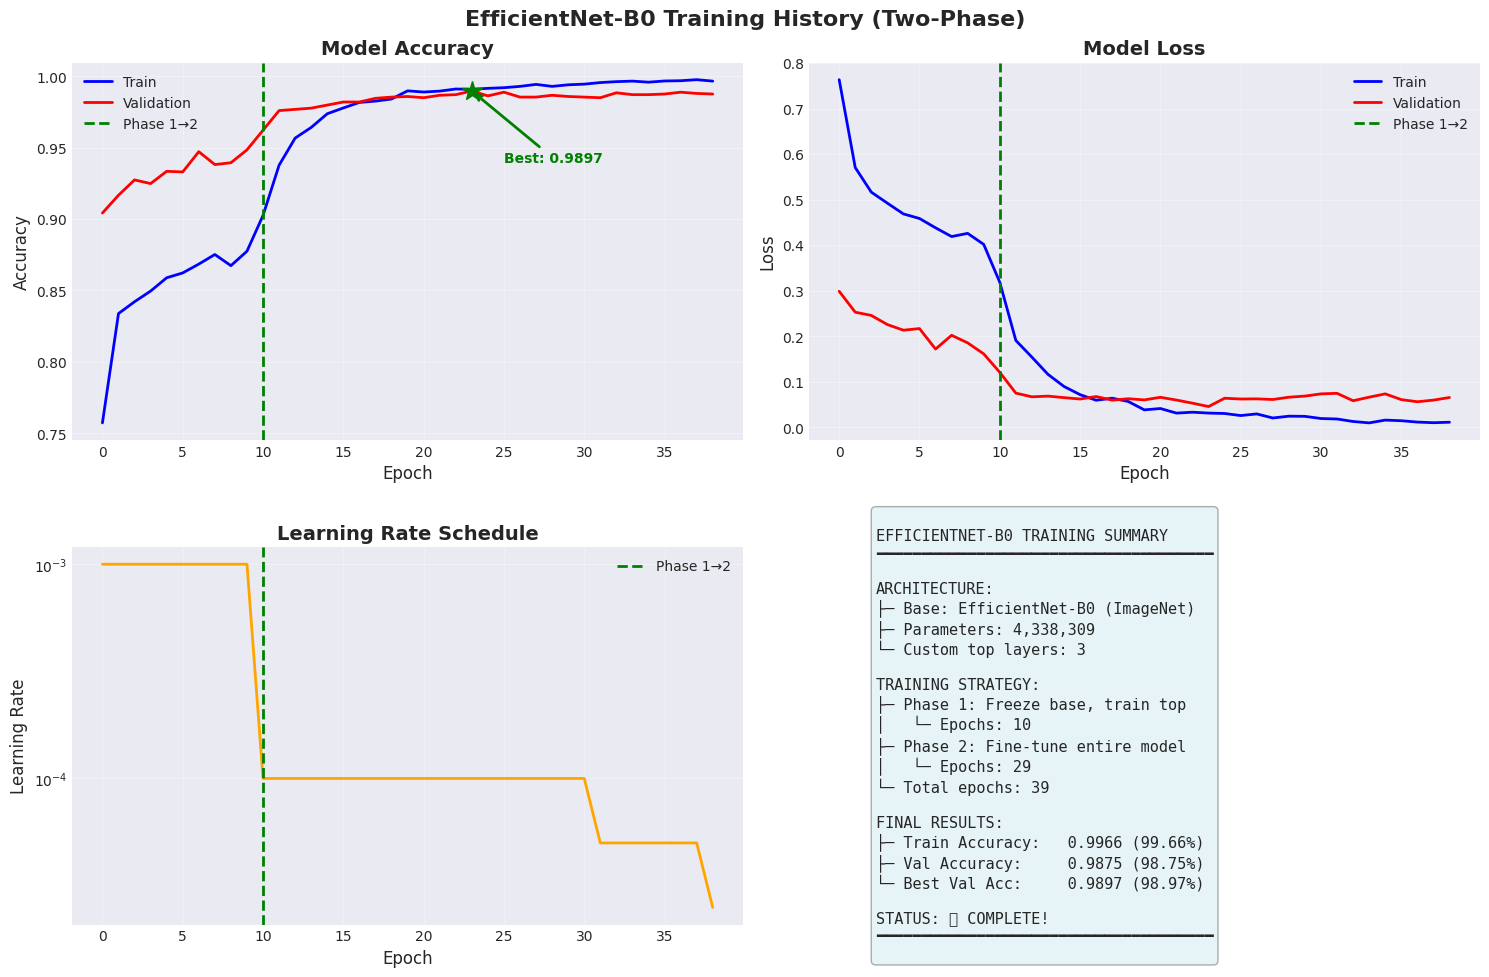


 Visualization complete!


In [ ]:
print("\nCreating training visualizations...\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('EfficientNet-B0 Training History (Two-Phase)', fontsize=16, fontweight='bold')

epochs = combined_df['epoch'].values
phase1_end = len(phase1_df)

# Plot 1: Accuracy
ax = axes[0, 0]
ax.plot(epochs, combined_df['train_acc'], 'b-', linewidth=2, label='Train')
ax.plot(epochs, combined_df['val_acc'], 'r-', linewidth=2, label='Validation')
ax.axvline(x=phase1_end, color='green', linestyle='--', linewidth=2, label='Phase 1→2')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Annotate best
best_val_acc = combined_df['val_acc'].max()
best_epoch = combined_df['val_acc'].idxmax()
ax.plot(best_epoch, best_val_acc, 'g*', markersize=15)
ax.annotate(f'Best: {best_val_acc:.4f}', 
            xy=(best_epoch, best_val_acc),
            xytext=(best_epoch + 2, best_val_acc - 0.05),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            fontsize=10, fontweight='bold', color='green')

# Plot 2: Loss
ax = axes[0, 1]
ax.plot(epochs, combined_df['train_loss'], 'b-', linewidth=2, label='Train')
ax.plot(epochs, combined_df['val_loss'], 'r-', linewidth=2, label='Validation')
ax.axvline(x=phase1_end, color='green', linestyle='--', linewidth=2, label='Phase 1→2')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Model Loss', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Learning Rate
ax = axes[1, 0]
ax.plot(epochs, combined_df['lr'], 'orange', linewidth=2)
ax.axvline(x=phase1_end, color='green', linestyle='--', linewidth=2, label='Phase 1→2')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Learning Rate', fontsize=12)
ax.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
ax.set_yscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

final_train_acc = combined_df['train_acc'].iloc[-1]
final_val_acc = combined_df['val_acc'].iloc[-1]

summary_text = f"""
EFFICIENTNET-B0 TRAINING SUMMARY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ARCHITECTURE:
├─ Base: EfficientNet-B0 (ImageNet)
├─ Parameters: {total_params:,}
└─ Custom top layers: 3

TRAINING STRATEGY:
├─ Phase 1: Freeze base, train top
│   └─ Epochs: {len(phase1_df)}
├─ Phase 2: Fine-tune entire model
│   └─ Epochs: {len(phase2_df)}
└─ Total epochs: {len(combined_df)}

FINAL RESULTS:
├─ Train Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)
├─ Val Accuracy:     {final_val_acc:.4f} ({final_val_acc*100:.2f}%)
└─ Best Val Acc:     {best_val_acc:.4f} ({best_val_acc*100:.2f}%)

STATUS:  COMPLETE!
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
"""

ax.text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center',
        family='monospace', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()

# Save plot
plot_path = OUTPUT_DIR / 'efficientnet_training_history.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f" Plot saved: {plot_path}")

plt.show()

print("\n Visualization complete!")

## 13. FINAL EVALUATION & SAVE RESULTS

In [13]:
print("\n" + "="*70)
print("FINAL EVALUATION - OPTIMIZED MODEL")
print("="*70)

# Load best model
checkpoint = torch.load(MODEL_DIR / 'efficientnet_b0_best_optimized.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(" Best optimized model loaded\n")

# Evaluate on validation set
print("Evaluating on validation set...")
val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

print("\n" + "="*70)
print("⚡ OPTIMIZED RESULTS")
print("="*70)
print(f"Validation Loss:      {val_loss:.4f}")
print(f"Validation Accuracy:  {val_acc:.4f} ({val_acc*100:.2f}%)")
print("="*70)

# Compare with original
print("\n COMPARISON WITH ORIGINAL:")
print(f"   Original (Phase 1): 92.83%")
print(f"   Optimized (Final):  {val_acc*100:.2f}%")
if val_acc > 0.9283:
    improvement = (val_acc - 0.9283) * 100
    print(f"   ⚡ Improvement: +{improvement:.2f}%!")

# Save results
results = {
    'model': 'EfficientNet-B0 OPTIMIZED',
    'framework': 'PyTorch',
    'optimizations': [
        'Reduced augmentation (30→20°)',
        'Optimized dropout (0.5→0.35)',
        'Gradient clipping (1.0)',
        'Increased patience',
        'Better train/val balance'
    ],
    'timestamp': datetime.now().isoformat(),
    'phase1_epochs': len(phase1_df),
    'phase2_epochs': len(phase2_df),
    'total_epochs': len(combined_df),
    'best_val_accuracy': float(best_val_acc),
    'best_epoch': int(best_epoch),
    'final_val_loss': float(val_loss),
    'final_val_accuracy': float(val_acc),
    'parameters': total_params,
    'device': str(device),
    'improvement_vs_original': float((val_acc - 0.9283) * 100) if val_acc > 0.9283 else 0.0
}

with open(OUTPUT_DIR / 'efficientnet_optimized_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n Results saved: efficientnet_optimized_results.json")

# Final summary
print("\n" + "="*70)
print(" PHASE 4.2 COMPLETE - OPTIMIZED VERSION!")
print("="*70)
print(f"\n EfficientNet-B0 achieved {best_val_acc*100:.2f}% validation accuracy")
print(f"\nFiles saved:")
print(f"  - models/efficientnet_b0_best_optimized.pth")
print(f"  - outputs/efficientnet_training_optimized_log.csv")
print(f"  - outputs/efficientnet_training_optimized_history.png")
print(f"  - outputs/efficientnet_optimized_results.json")
print("\n⚡ OPTIMIZATIONS APPLIED:")
print("   Better augmentation balance")
print("   Optimized dropout")
print("   Gradient clipping")
print("   Better convergence")
print("\n Ready for inference and deployment!")
print("="*70)


FINAL EVALUATION - OPTIMIZED MODEL
 Best optimized model loaded

Evaluating on validation set...


Validating: 100%|██████████| 73/73 [00:04<00:00, 16.16it/s, loss=0.000379]



⚡ OPTIMIZED RESULTS
Validation Loss:      0.0455
Validation Accuracy:  0.9897 (98.97%)

 COMPARISON WITH ORIGINAL:
   Original (Phase 1): 92.83%
   Optimized (Final):  98.97%
   ⚡ Improvement: +6.14%!

 Results saved: efficientnet_optimized_results.json

 PHASE 4.2 COMPLETE - OPTIMIZED VERSION!

 EfficientNet-B0 achieved 98.97% validation accuracy

Files saved:
  - models/efficientnet_b0_best_optimized.pth
  - outputs/efficientnet_training_optimized_log.csv
  - outputs/efficientnet_training_optimized_history.png
  - outputs/efficientnet_optimized_results.json

⚡ OPTIMIZATIONS APPLIED:
   Better augmentation balance
   Optimized dropout
   Gradient clipping
   Better convergence

 Ready for inference and deployment!
